In [12]:
import os
import tensorflow as tf
import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.densenet import DenseNet169,preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load Data 

In [22]:
# train_df
train_df=image_dataset_from_directory(
    '/kaggle/input/food-photos-final/food photos/train',
    image_size=(224,224),
    label_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=32
)

#valid_df
valid_df=image_dataset_from_directory(
    '/kaggle/input/food-photos-final/food photos/valid',
    image_size=(224,224),
    label_mode='categorical',
    seed=42,
    shuffle=False,
    batch_size=32
    )

Found 765 files belonging to 9 classes.
Found 180 files belonging to 9 classes.


In [6]:
# test_df
test_df=image_dataset_from_directory(
    '/kaggle/input/food-photos-final/food photos/test',
    image_size=(224,224),
    batch_size=32,
    label_mode='categorical',
    seed=42
)

Found 135 files belonging to 9 classes.


In [23]:
train_df

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [24]:
valid_df

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [7]:
test_df

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [8]:
classes_names=test_df.class_names
print(classes_names)

['Fattah', 'Fool', 'Hawawshy', 'Koshari', 'Kunafa', 'Mahshy El Kosa', 'Ptata', 'Taameya', 'Umm Ali']


In [72]:
# # normalize data
# def normalize_img(image, label):
#     return tf.cast(image, tf.float32) / 255.0, label

# train_df = train_df.map(normalize_img)
# valid_df = valid_df.map(normalize_img)
# test_df = test_df.map(normalize_img)

In [25]:
# better data read and put data in cache 
AUTOTUNE = tf.data.AUTOTUNE
train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
valid_df = valid_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

# import DenseNet Model

In [122]:
base_model=DenseNet169(include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 12,484,480 (47.62 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [123]:
# Freeze Trainable Params
base_model.trainable=False
base_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

# Bulid and Train Model

In [124]:
#bulid model

def bulid_model():
  inputs=layers.Input(shape=(224,224,3))
  hidd=layers.Lambda(preprocess_input)(inputs)
  hidd=base_model(hidd)
  #bulid attention mechanism layers
  att=layers.GlobalAveragePooling2D()(hidd)
  att=layers.Dense(1664//16,activation='relu')(att)
  att=layers.Dense(1664,activation='sigmoid')(att)
  att = layers.Reshape((1, 1, 1664))(att)
  hidd=layers.Multiply()([hidd,att])
  hidd=layers.GlobalAveragePooling2D()(hidd)

  #Fully connected Layers
  hidd=layers.Dropout(0.3)(hidd)
  hidd=layers.Dense(128,activation='relu',kernel_regularizer=l2(0.002))(hidd)
  hidd=layers.Dense(64,activation='relu',kernel_regularizer=l2(0.002))(hidd)
  hidd=layers.Dense(32,activation='relu',kernel_regularizer=l2(0.002))(hidd)
  outputs=layers.Dense(9,activation='softmax')(hidd)

  return inputs,outputs

inputs,outputs=bulid_model()
model=models.Model(inputs,outputs)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ lambda_4[0][0]    │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 104)       │    173,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1664)      │    174,720 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1,      │          0 │ dense_25[0][0]    │
│                     │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7,      │          0 │ densenet169[0][0… │
│ (Multiply)          │ 1664)             │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ multiply_4[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │    213,120 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 9)         │        297 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,214,513 (50.41 MB)

 Trainable params: 571,633 (2.18 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [125]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_final_5.keras', monitor='val_loss', save_best_only=True)

In [126]:
history=model.fit(train_df,validation_data=valid_df,batch_size=32,
                  epochs=15 , callbacks=[early_stopping, model_checkpoint])

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.1460 - loss: 2.9344 - val_accuracy: 0.1722 - val_loss: 2.8338
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.1926 - loss: 2.8119 - val_accuracy: 0.3000 - val_loss: 2.7460
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.2871 - loss: 2.7098 - val_accuracy: 0.4111 - val_loss: 2.6358
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.3365 - loss: 2.6015 - val_accuracy: 0.4500 - val_loss: 2.5055
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.4468 - loss: 2.4460 - val_accuracy: 0.5056 - val_loss: 2.3384
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.5078 - loss: 2.2811 - val_accuracy: 0.6000 - val_loss: 2.1328
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.5547 - loss: 2.0689 - val_accuracy: 0.6444 - val_loss: 1.9259
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.6375 - loss: 1.8879 - val_accuracy: 0.71

In [127]:
best_model = tf.keras.models.load_model(
    "/kaggle/working/best_final_5.keras",
    custom_objects={'preprocess_input': preprocess_input}
)

In [128]:
test_loss, test_accuracy=best_model.evaluate(test_df)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8609 - loss: 1.0383
Test Accuracy: 0.8666666746139526
Test loss: 1.0084699392318726


In [129]:
history_dict=history.history

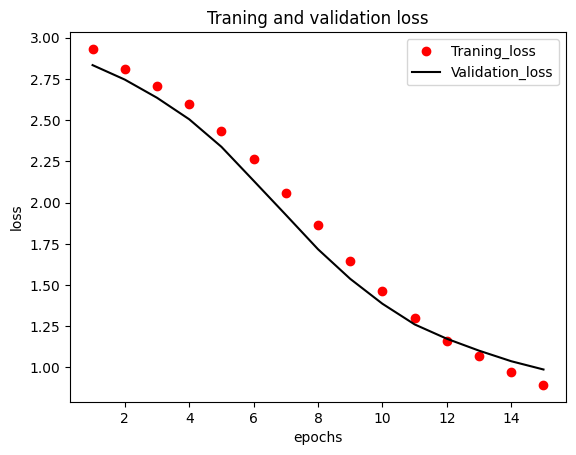

In [130]:
loss_value=history_dict['loss']
val_loss_value=history_dict['val_loss']
epochs=range(1,16)
plt.figure()
plt.plot(epochs,loss_value,'ro',label='Traning_loss')
plt.plot(epochs,val_loss_value,'k-',label='Validation_loss')
plt.title('Traning and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

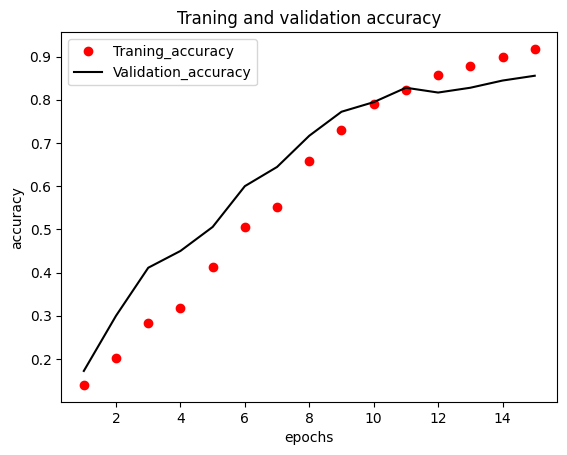

In [131]:
loss_value=history_dict['accuracy']
val_loss_value=history_dict['val_accuracy']
epochs=range(1,16)
plt.figure()
plt.plot(epochs,loss_value,'ro',label='Traning_accuracy')
plt.plot(epochs,val_loss_value,'k-',label='Validation_accuracy')
plt.title('Traning and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [132]:
best_model.save('best_model_final_5.h5')

# Transfer Learning

In [72]:
best_model = keras.models.load_model(
    "/kaggle/input/best-model-final-5/keras/default/1/best_final_5.keras",
    custom_objects={'preprocess_input': preprocess_input}
)

best_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ lambda_4[0][0]    │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 104)       │    173,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1664)      │    174,720 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1,      │          0 │ dense_25[0][0]    │
│                     │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7,      │          0 │ densenet169[0][0… │
│ (Multiply)          │ 1664)             │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ multiply_4[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │    213,120 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 9)         │        297 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,357,781 (54.77 MB)

 Trainable params: 571,633 (2.18 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

 Optimizer params: 1,143,268 (4.36 MB)

In [89]:
base_model = best_model.get_layer('densenet169')
base_model.trainable = True
for layer in base_model.layers[:-8]:
    layer.trainable = False
trainable_count = sum(layer.trainable for layer in base_model.layers)
print(f"Trainable layers: {trainable_count} / {len(base_model.layers)}")

Trainable layers: 6 / 595


In [90]:
best_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ lambda_4[0][0]    │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 104)       │    173,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1664)      │    174,720 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1,      │          0 │ dense_25[0][0]    │
│                     │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7,      │          0 │ densenet169[0][0… │
│ (Multiply)          │ 1664)             │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ multiply_4[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │    213,120 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 9)         │        297 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,357,781 (54.77 MB)

 Trainable params: 612,081 (2.33 MB)

 Non-trainable params: 12,602,432 (48.07 MB)

 Optimizer params: 1,143,268 (4.36 MB)

In [64]:
# setting_training= False
# base_model = best_model.get_layer('densenet169')
# for layer in base_model.layers:
#     if 'conv5_block32' in layer.name or 'conv5_block31' in layer.name:
#         setting_training= True
#         print(layer.name)
#     layer.trainable=setting_training
#     # print(layer.trainable)
# trainable_count = sum(layer.trainable for layer in base_model.layers)
# print(f"Trainable layers: {trainable_count} / {len(base_model.layers)}")

In [91]:
best_model.save('best_model_final_trainable_5_8.keras')

In [105]:
fine_tuned_model = keras.models.load_model(
    "/kaggle/working/best_model_final_trainable_5_8.keras",
    custom_objects={'preprocess_input': preprocess_input}
)

fine_tuned_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ lambda_4[0][0]    │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 104)       │    173,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1664)      │    174,720 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1,      │          0 │ dense_25[0][0]    │
│                     │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7,      │          0 │ densenet169[0][0… │
│ (Multiply)          │ 1664)             │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ multiply_4[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │    213,120 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 9)         │        297 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,438,677 (55.08 MB)

 Trainable params: 612,081 (2.33 MB)

 Non-trainable params: 12,602,432 (48.07 MB)

 Optimizer params: 1,224,164 (4.67 MB)

In [106]:
fine_tuned_model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping_tuned = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_tuned = ModelCheckpoint('best_model_tuned_final_5_8.keras', monitor='val_loss', save_best_only=True)

In [107]:
fine_tuned_history=fine_tuned_model.fit(train_df,validation_data=valid_df,batch_size=32,epochs=20)

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8895 - loss: 0.9489 - val_accuracy: 0.8389 - val_loss: 0.9937
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9191 - loss: 0.8778 - val_accuracy: 0.8500 - val_loss: 0.9823
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9269 - loss: 0.8285 - val_accuracy: 0.8611 - val_loss: 0.9502
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9456 - loss: 0.7761 - val_accuracy: 0.8722 - val_loss: 0.9054
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9206 - loss: 0.7496 - val_accuracy: 0.8722 - val_loss: 0.8937
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9464 - loss: 0.7216 - val_accuracy: 0.8667 - val_loss: 0.8711
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9643 - loss: 0.6631 - val_accuracy: 0.8778 - val_loss: 0.8470
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9397 - loss: 0.6877 - val_accuracy: 0.86

In [108]:
test_loss, test_accuracy=fine_tuned_model.evaluate(test_df)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8934 - loss: 0.7718 
Test Accuracy: 0.8962963223457336
Test loss: 0.7512366771697998


In [109]:
fine_tuned_model.save("fine_tuned_model_5_8_1.keras")

In [110]:
history_dict_tuned=fine_tuned_history.history

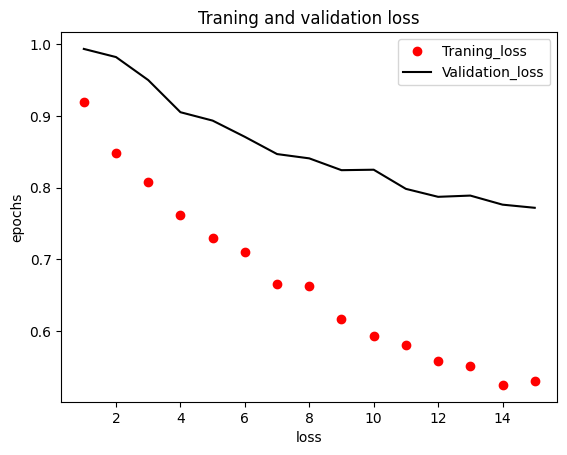

In [112]:
loss_value=history_dict_tuned['loss']
val_loss_value=history_dict_tuned['val_loss']
epochs=range(1,16)
plt.figure()
plt.plot(epochs,loss_value,'ro',label='Traning_loss')
plt.plot(epochs,val_loss_value,'k-',label='Validation_loss')
plt.title('Traning and validation loss')
plt.xlabel('loss')
plt.ylabel('epochs')
plt.legend()
plt.show()

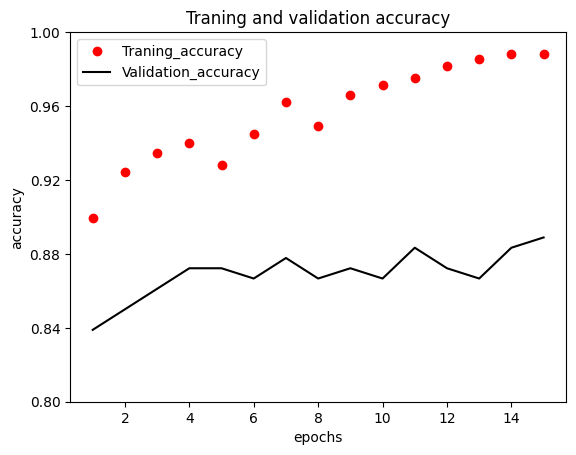

In [113]:
loss_value=history_dict_tuned['accuracy']
val_loss_value=history_dict_tuned['val_accuracy']
epochs=range(1,16)
plt.figure()
plt.plot(epochs,loss_value,'ro',label='Traning_accuracy')
plt.plot(epochs,val_loss_value,'k-',label='Validation_accuracy')
plt.yticks([0.8,0.84,0.88,0.92,0.96,1.0])
plt.title('Traning and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Compare between models test results

In [114]:
# upload best_model again before unfreeze layers
best_model_test = keras.models.load_model(
    "/kaggle/input/best-model-final-5/keras/default/1/best_final_5.keras",
    custom_objects={'preprocess_input': preprocess_input}
)

best_model_test.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ lambda_4[0][0]    │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 104)       │    173,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1664)      │    174,720 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1,      │          0 │ dense_25[0][0]    │
│                     │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7,      │          0 │ densenet169[0][0… │
│ (Multiply)          │ 1664)             │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ multiply_4[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │    213,120 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 9)         │        297 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,357,781 (54.77 MB)

 Trainable params: 571,633 (2.18 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

 Optimizer params: 1,143,268 (4.36 MB)

In [115]:
img = image.load_img('/kaggle/input/food-photos-final/food photos/test/Taameya/الطعمية المصرية_0.jpg',
                     target_size=(224, 224))

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
[[0.19494507 0.05177016 0.01088638 0.04160203 0.08690335 0.20285581
  0.03727405 0.22247209 0.1512911 ]]
7


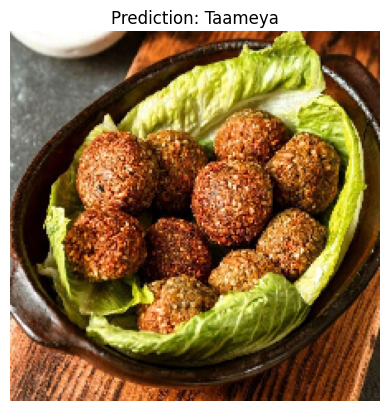

In [116]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = best_model_test.predict(x)
pred_class = np.argmax(preds, axis=1)[0]
print(preds)
print(pred_class)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {classes_names[pred_class]}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
[[0.21284908 0.02622169 0.01409947 0.00404365 0.04782579 0.26258126
  0.00334054 0.279537   0.14950155]]
7


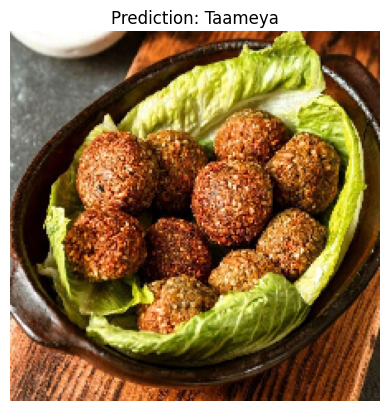

In [117]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = fine_tuned_model.predict(x)
pred_class = np.argmax(preds, axis=1)[0]
print(preds)
print(pred_class)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {classes_names[pred_class]}")
plt.show()
